In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches

from tqdm.notebook import tqdm

from gwpy.timeseries import TimeSeries
from ts_outlier_detection import *
from ts_outlier_detection.plotting import *
from utils import stdev_loss

## TOF Figure

The top left plot is an example of a "Tomte" transient noise event in a gravitational wave interferometer strain data time series (sampling rate of 4192 Hz). The corresponding Temporal Outlier Factors for each point in the data series are shown in the bottom left plot, with circles corresponding to points with TOFs below the detection threshold. The right side plot shows the corresponding two-dimensional phase space generated via the time-delay embedding procedure (using the default delay of one sample). The TOF calculations were performed with an embedding dimension of 2, spatial clustering of 9 nearest neighbors, and a maximum detectable event length of 1024 samples.

In [2]:
GLITCH_EXAMPLE = 1250540898.895

ts = TimeSeries.fetch('L1:GDS-CALIB_STRAIN', GLITCH_EXAMPLE-4, GLITCH_EXAMPLE+4).whiten().bandpass(20, 500)
data = ts.value
times = ts.times.value
select = (times > GLITCH_EXAMPLE-2) & (times < GLITCH_EXAMPLE+2)
data = data[select]
times = times[select]

ctof = TemporalOutlierFactor(dims=2, n_neighbors=9, event_length=1024)
ctof.fit(data, times)

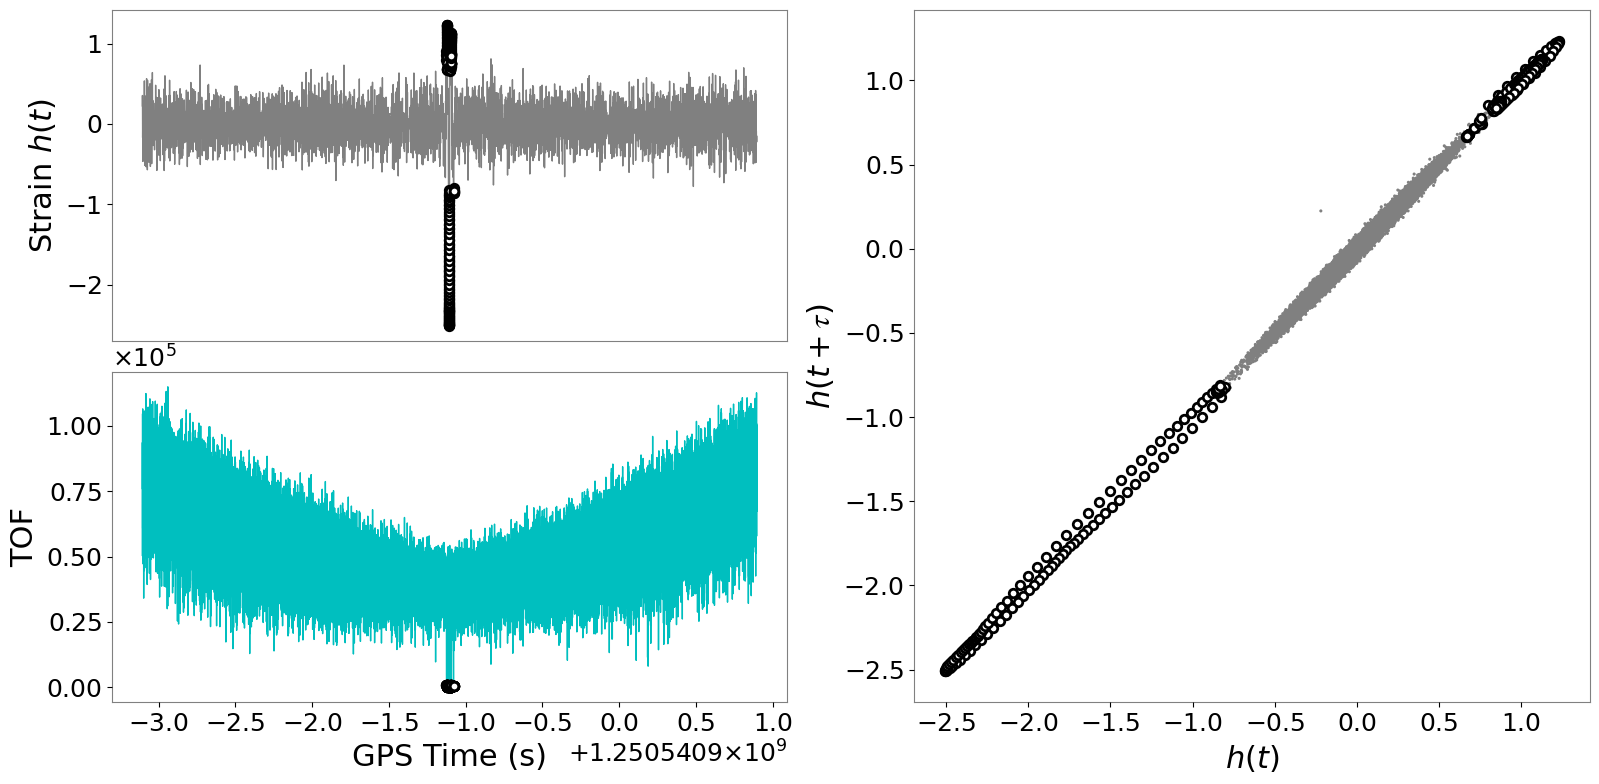

In [4]:
plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2)

sqr = fig.add_subplot(gs[:, 1])
top = fig.add_subplot(gs[0, 0])
btm = fig.add_subplot(gs[1, 0])

top.plot(times, data, color='grey', linewidth=1, zorder=0)
outliers = ctof.get_outlier_indices()
top.scatter(
    times[outliers], data[outliers],
    s=150, facecolors='w', edgecolors='k', linewidth=2, marker='.', zorder=1
)
tofs = ctof.get_outlier_factors()
btm.plot(times, tofs, color='c', linewidth=1, zorder=0)
btm.scatter(
    times[outliers], tofs[outliers],
    s=150, facecolors='w', edgecolors='k', linewidth=2, marker='.', zorder=1
)
plot_2d_scatter(
    ctof.get_embedded_data(), sqr, ctof.get_outlier_indices(),
    scatter_style={'s': 5, 'facecolors': 'grey', 'edgecolors': 'none'},
    outlier_style={'s': 150, 'facecolors': 'w', 'edgecolors': 'k', 'linewidth': 2, 'marker': '.'}
)

top.set_xticks([])
top.set_ylabel('Strain $h(t)$')
top.grid(False)

btm.set_xlabel('GPS Time (s)')
btm.set_ylabel('TOF')
btm.grid(False)

sqr.set_xlabel('$h(t)$')
sqr.set_ylabel('$h(t+𝜏)$')
sqr.grid(False)
fig.tight_layout(h_pad=0)
plt.savefig('data/fig1.pdf', bbox_inches='tight')

## Loss Figure

Visual demonstration of how the loss function quantitatively defines a "good" anomaly detection. For any particular tunable parameter, there is a range where the detections are "noisy": many points outside of the actual anomaly are classified as anomalous. Conversely, there is typically another range where detections are sparse or non-existent. Somewhere in the middle is a "sweet spot", where there are many detections at the site of the anomaly and few elsewhere---this corresponds to a dip in the loss.

In [2]:
GLITCH = 1251977072
ts = TimeSeries.fetch('H1:GDS-CALIB_STRAIN', GLITCH-4, GLITCH+4).whiten().bandpass(20, 500)
data = ts.value
times = ts.times.value
window = (times > GLITCH-2) & (times < GLITCH+2)
data = data[window]
times = times[window]

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/io/nds2.py:293: NDSWarning: Error authenticating against nds.ligo.caltech.edu:31200
  warnings.warn('Error authenticating against {0}:{1}'.format(host, port),


Please provide username for the LIGO.ORG kerberos realm: julian.ding
Password for julian.ding@LIGO.ORG: ········
Kerberos ticket generated for julian.ding@LIGO.ORG


In [3]:
losses = []
outliers = []
tofs = []

n_range = np.arange(2, 41)
for k in tqdm(n_range):
    ctof = TemporalOutlierFactor(n_neighbors=k, event_length=1024)
    ctof.fit(data, times)
    tofs.append(ctof.get_outlier_factors())
    outlier_ids = ctof.get_outlier_indices()
    outliers.append(outlier_ids)
    loss = stdev_loss(GLITCH, times[outlier_ids])
    losses.append(loss)

  0%|          | 0/39 [00:00<?, ?it/s]

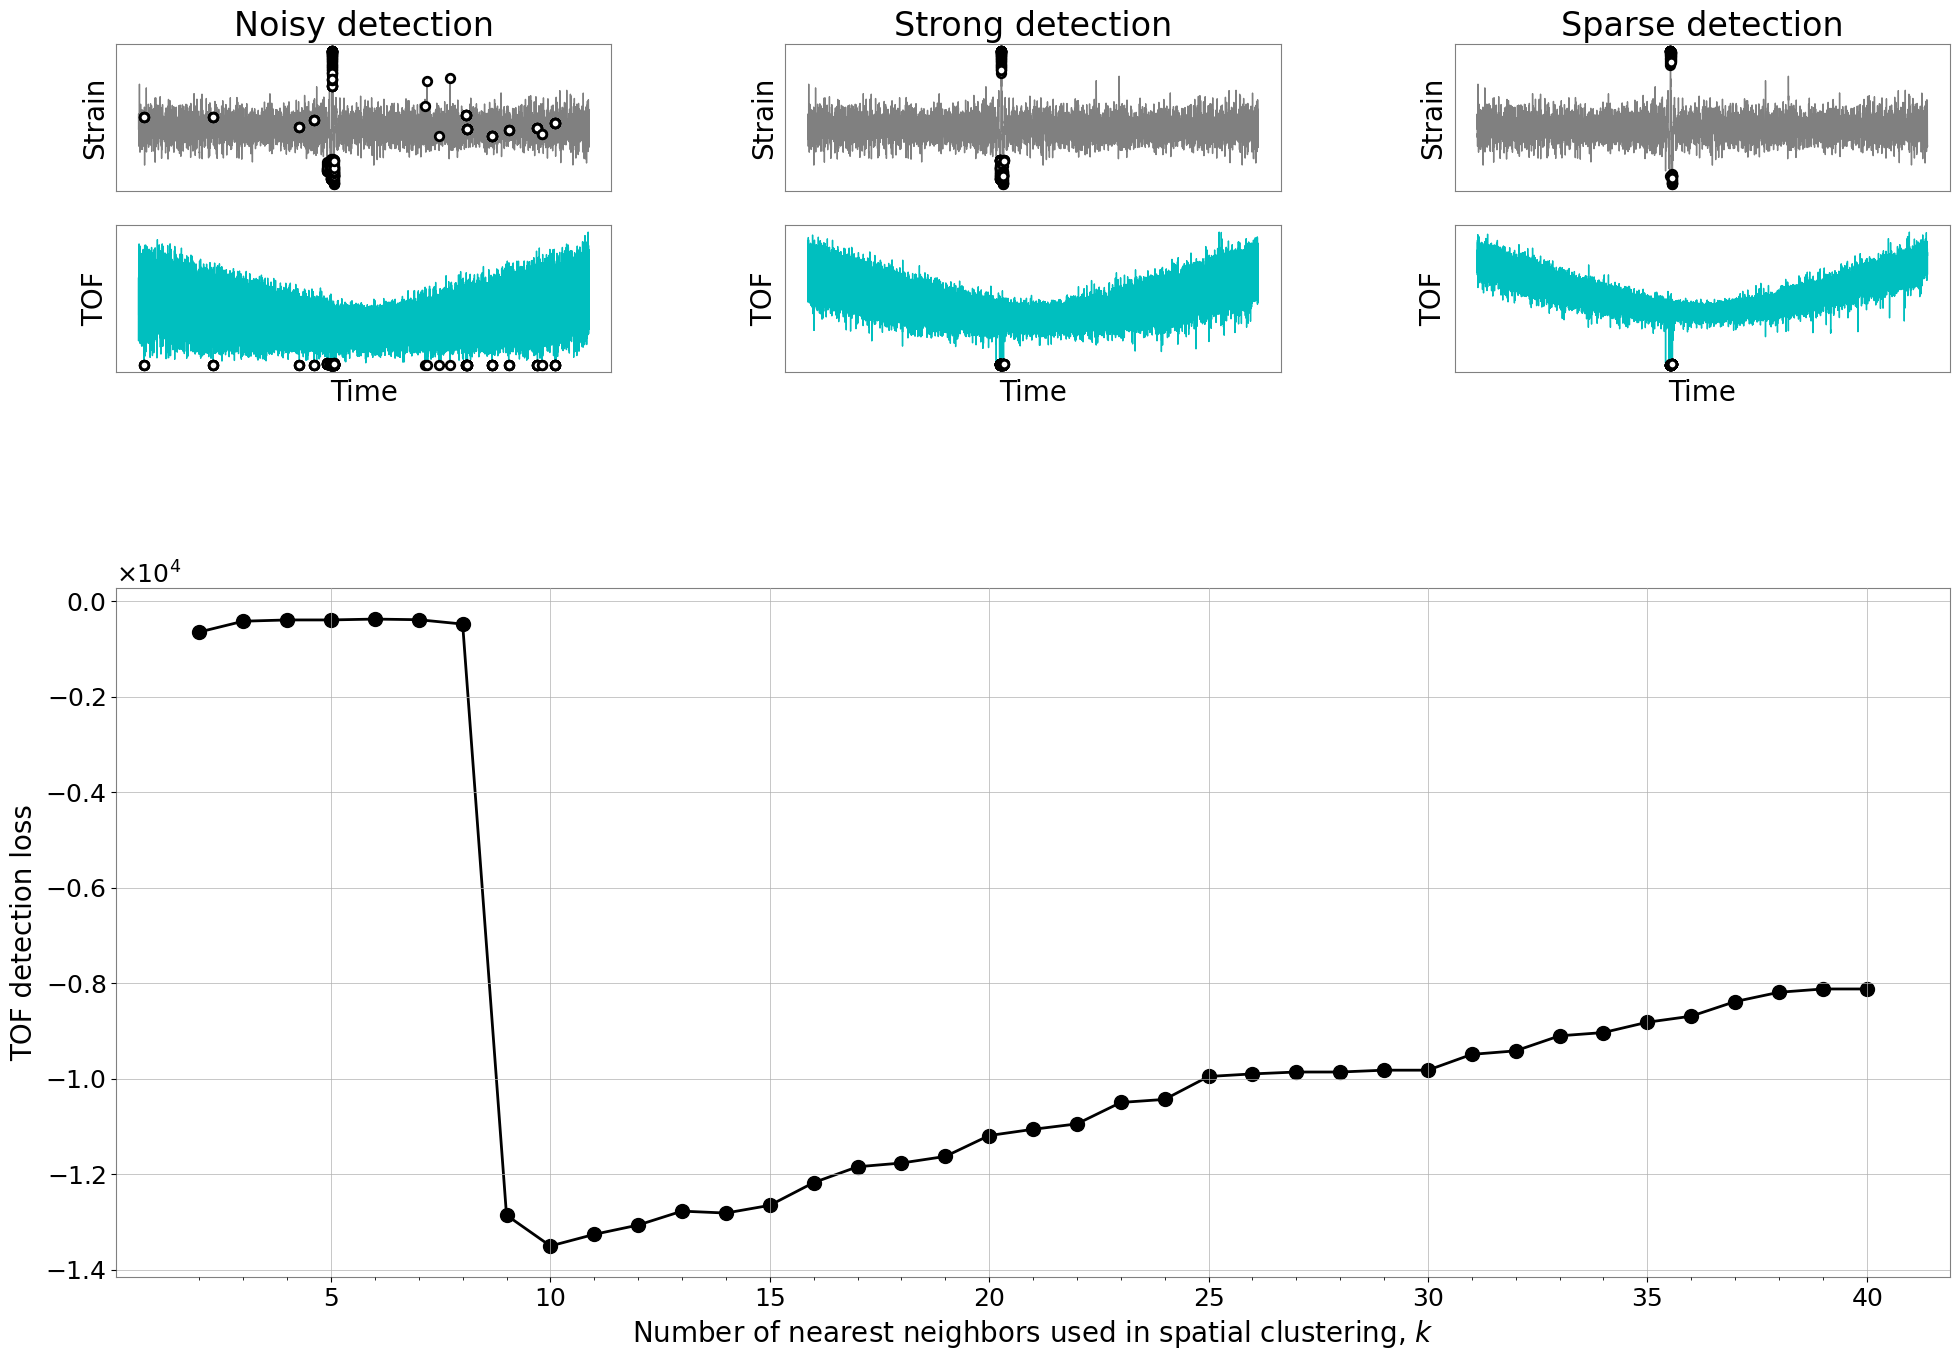

In [8]:
from matplotlib.patches import ConnectionPatch

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

fig = plt.figure(figsize=(20,14))
grid_shape = (7, 3)
axrows = 1
noisy_stn = plt.subplot2grid(grid_shape, (0, 0), rowspan=axrows)
noisy_tof = plt.subplot2grid(grid_shape, (axrows, 0), rowspan=axrows)
good_stn = plt.subplot2grid(grid_shape, (0, 1), rowspan=axrows)
good_tof = plt.subplot2grid(grid_shape, (axrows, 1), rowspan=axrows)
poor_stn = plt.subplot2grid(grid_shape, (0, 2), rowspan=axrows)
poor_tof = plt.subplot2grid(grid_shape, (axrows, 2), rowspan=axrows)
lmap = plt.subplot2grid(grid_shape, (grid_shape[0]-4*axrows, 0), rowspan=4*axrows, colspan=3)

lmap.plot(n_range, losses, 'k.-', linewidth=2, markersize=20)
lmap.set_xticks(n_range, minor=True)
lmap.set_xlabel('Number of nearest neighbors used in spatial clustering, $k$')
lmap.set_ylabel('TOF detection loss')
lmap.grid(True)

noisy_i = 2
good_i = 10
poor_i = -1

for i, stn_ax, tof_ax, label in zip(
    [noisy_i, good_i, poor_i],
    [noisy_stn, good_stn, poor_stn],
    [noisy_tof, good_tof, poor_tof],
    ['Noisy detection', 'Strong detection', 'Sparse detection']
):
    outlier_ids = outliers[i]
    stn_ax.plot(times-GLITCH, data, color='grey', linewidth=1,  zorder=0)
    stn_ax.scatter(
        times[outlier_ids]-GLITCH, data[outlier_ids],
        s=150, facecolors='w', edgecolors='k', linewidth=2, marker='.', zorder=1
    )
    stn_ax.set_title(label)
    stn_ax.set_xticks([])
    stn_ax.set_ylabel('Strain')
    stn_ax.set_yticks([])
    stn_ax.grid(False)
    
    tof_ax.plot(times-GLITCH, tofs[i], color='c', linewidth=1, zorder=0)
    tof_ax.scatter(
        times[outlier_ids]-GLITCH, tofs[i][outlier_ids],
        s=150, facecolors='w', edgecolors='k', linewidth=2, marker='.', zorder=1
    )
    tof_ax.set_xlim(*stn_ax.get_xlim())
    tof_ax.set_xlabel('Time')
    tof_ax.set_xticks([])
    tof_ax.set_ylabel('TOF')
    tof_ax.set_yticks([])
    tof_ax.grid(False)

fig.tight_layout(h_pad=0, w_pad=5)
plt.savefig('data/loss_function.pdf', bbox_inches='tight')

## Heatmap Figure

(Top plots) Representative examples of three types of well-known transient noise signatures found in detector data ("glitches"), each displayed as a q-transform spectrogram. (Bottom plots) Aggregated results of TOF parameter grid search using 150 examples of each glitch type as validated by the loss function described by Equation (?). Depicted is the summed loss over all examples, linearly scaled so the range falls between $[-1,0]$. During the grid search, the TOF embedding dimension was kept constant at 3.

In [11]:
KOI_FISH = ('H1', 1239105092.245)
REPEATING_BLIP = ('H1', 1241577499.486)
TOMTE = ('L1', 1250540898.895)
glitches = [KOI_FISH, REPEATING_BLIP, TOMTE]
glitch_ts = [TimeSeries.fetch_open_data(det, gps-2, gps+2) for det, gps in glitches]

NameError: name 'glitch_ts' is not defined

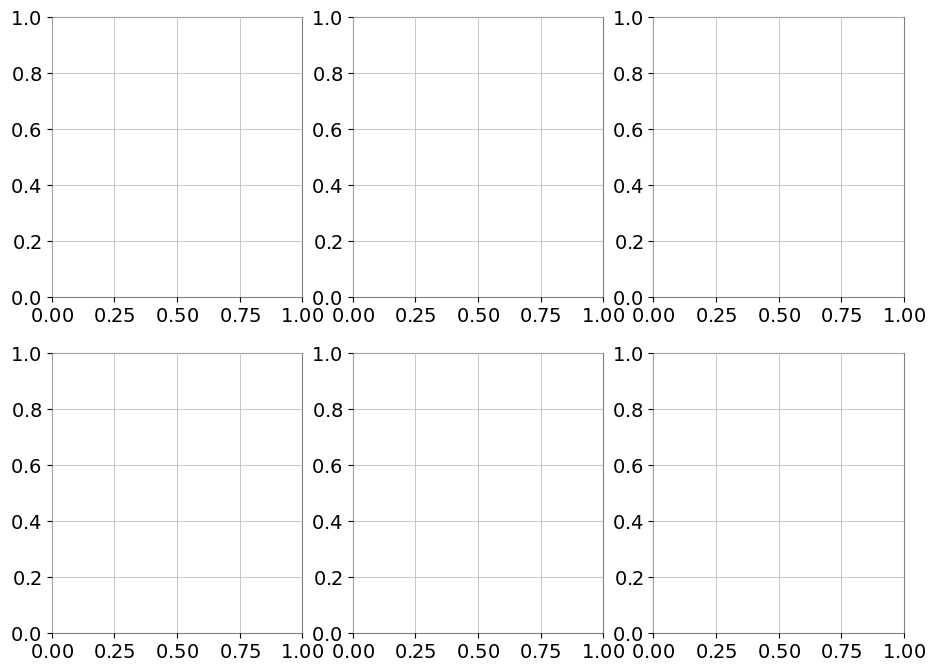

In [9]:
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
fig, axs = plt.subplots(2, 3, figsize=(11, 8))

# Examples

for i, ts in enumerate(glitch_ts):
    gps = glitches[i][-1]
    ax = axs[0,i]
    ax.imshow(ts.q_transform(outseg=(gps-0.5, gps+0.5), qrange=(4, 64), frange=(15, 2048), fres=0.5), vmin=0, vmax=25)
    ax.set_yscale('log', base=2)
    ax.grid(False)
    x0, x1 = ax.get_xlim()
    ax.set_xticks([x0, x0+(x1-x0)/2, x1])
    ax.set_xticklabels([0, 0.5, 1])
    if i > 0:
        ax.set_yticks([])
    if i+1 == len(glitch_ts):
        cbar = ax.colorbar()
        cbar.set_label('Normalized energy')

axs[0,0].set_title('Koi Fish')
axs[0,1].set_title('Repeating Blips')
axs[0,2].set_title('Tomte')

# Losses

k0 = 2
k1 = 40
m0 = 300
m1 = 2000
koi_fish_losses = np.loadtxt('data/koi_fish_grid_search/aggregate_using_sum_loss_normalized.csv', delimiter=',')
rep_blip_losses = np.loadtxt('data/repeating_blips_grid_search/aggregate_using_sum_loss_normalized.csv', delimiter=',')
tomte_losses = np.loadtxt('data/tomte_grid_search/aggregate_using_sum_loss_normalized.csv', delimiter=',')
loss_maps = [koi_fish_losses, rep_blip_losses, tomte_losses]

for i, loss_map in enumerate(loss_maps):
    ax = axs[1,i]
    ax.imshow(loss_map[:38], extent=[k0, k1, m0, m1], aspect=(k1-k0)/(m1-m0), vmin=-1, vmax=0, cmap='Greens_r')
    ax.grid(False)
    if i > 0:
        ax.set_yticks([])
    if i+1 == len(glitch_ts):
        cbar = ax.colorbar()
        cbar.set_label('Normalized loss')
        cbar.set_ticks([-1, -0.5, 0])

fig.text(0.52, 0.5, 'Time (s)', ha='center')
fig.text(0.52, 0, 'Number of nearest neighbors used in spatial clustering, $k$', ha='center')
fig.text(0, 0.65, 'Frequency (Hz)', rotation=90, va='baseline')
fig.text(0, 0.17, 'Event length, $M$', rotation=90)
    
fig.tight_layout(h_pad=3.5, w_pad=0.5, pad=1.5)
plt.savefig('data/fig2.pdf', bbox_inches='tight')

## Pipeline Figure

Demonstration of the rescaling effect of using data windows of differing size. The spectrogram shown is of retracted Open Public Alert S190518bb corresponding to a minor earthquake at the Hanford interferometer. TOF is unable to determine the excess power from the earthquake as an anomaly using the 4-second window. The 30-second window results only a partial detection. The 120-second window results in a full detection of the anomaly. Note also the effects of resampling on the signal amplitude.

In [5]:
QUAKE = 1242242376.47
rdata = TimeSeries.fetch_open_data('H1', QUAKE-500, QUAKE+300)
hdata = rdata.whiten().bandpass(20, 500)

In [7]:
GLITCH = 1242242260
WINDOWS = [
    (QUAKE-4, QUAKE),
    (QUAKE-20, QUAKE+10),
    (QUAKE-80, QUAKE+40)
]

def get_window(ts, t0, t1, resample=None):
    times = ts.times.value
    ts = ts[(times > t0) & (times < t1)]
    if resample:
        ts = ts.resample(resample)
    return ts.value, ts.times.value

base_data, base_times = get_window(hdata, *WINDOWS[0])
base_length = base_times.size

ctofs = [TemporalOutlierFactor(dims=3, n_neighbors=9, event_length=1600) for _ in range(3)]
for ctof, window in zip(ctofs, WINDOWS):
    resample = base_length / abs(window[0] - window[1])
    ctof.fit(*get_window(hdata, *window, resample=resample))
    
left = np.arange(QUAKE-500, QUAKE+300, 4)
right = left + 4
right[right > QUAKE+300] = QUAKE+300
sub_windows = np.stack((left, right), axis=-1)
qsan_segments = [
    rdata.q_transform(outseg=(lt, rt), qrange=(4, 64), frange=(15, 2048), fres=0.5) for lt, rt in tqdm(sub_windows)]
qscan = np.concatenate(qsan_segments, axis=0)

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:925: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


  0%|          | 0/200 [00:00<?, ?it/s]

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '


In [8]:
from collections import defaultdict

def _generate_windows(start, stop, level, offset):
    step = offset * level
    left = np.arange(start, stop, step)
    right = left + level
    right[right > stop] = stop
    return np.stack((left, right), axis=-1)

start = QUAKE-500
stop = QUAKE+300
level_windows = {level: _generate_windows(start, stop, level, 0.5) for level in [4, 30, 120]}

outlier_times = defaultdict(lambda: np.array([]))
ctof = TemporalOutlierFactor(dims=3, n_neighbors=9, event_length=1600)
samples = 4 * rdata.sample_rate

for level, windows in level_windows.items():
    resampled_data = hdata.resample(samples / level)
    for left, right in tqdm(windows, desc=f'Windows of length {level}'):
        wdata = resampled_data[(resampled_data.times.value >= left) & (resampled_data.times.value < right)]
        data = wdata.value
        times = wdata.times.value
        ctof.fit(data, times)
        outliers = times[ctof.get_outlier_indices()]
        outliers = outliers[(outliers >= start) & (outliers < stop)]
        outlier_times[level] = np.append(outlier_times[level], outliers)

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/timeseries/timeseries.py:925: UserWarning: resample() rate matches current sample_rate (4096.0 Hz), returning input data unmodified; please double-check your parameters
  warnings.warn(


Windows of length 4:   0%|          | 0/400 [00:00<?, ?it/s]

Windows of length 30:   0%|          | 0/54 [00:00<?, ?it/s]

Windows of length 120:   0%|          | 0/14 [00:00<?, ?it/s]

/home/azimuth/.local/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/azimuth/.local/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
/home/azimuth/.local/lib/python3.9/site-packages/gwpy/signal/qtransform.py:124: UserWarning: upper frequency of 2048.00 is too high for the given Q range, resetting to 1291.05
  warnings.warn('upper frequency of %.2f is too high for the given '
<ipython-input-9-8fa944c8af8d>:100: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout(w_pad=0, h_pad=0.1)


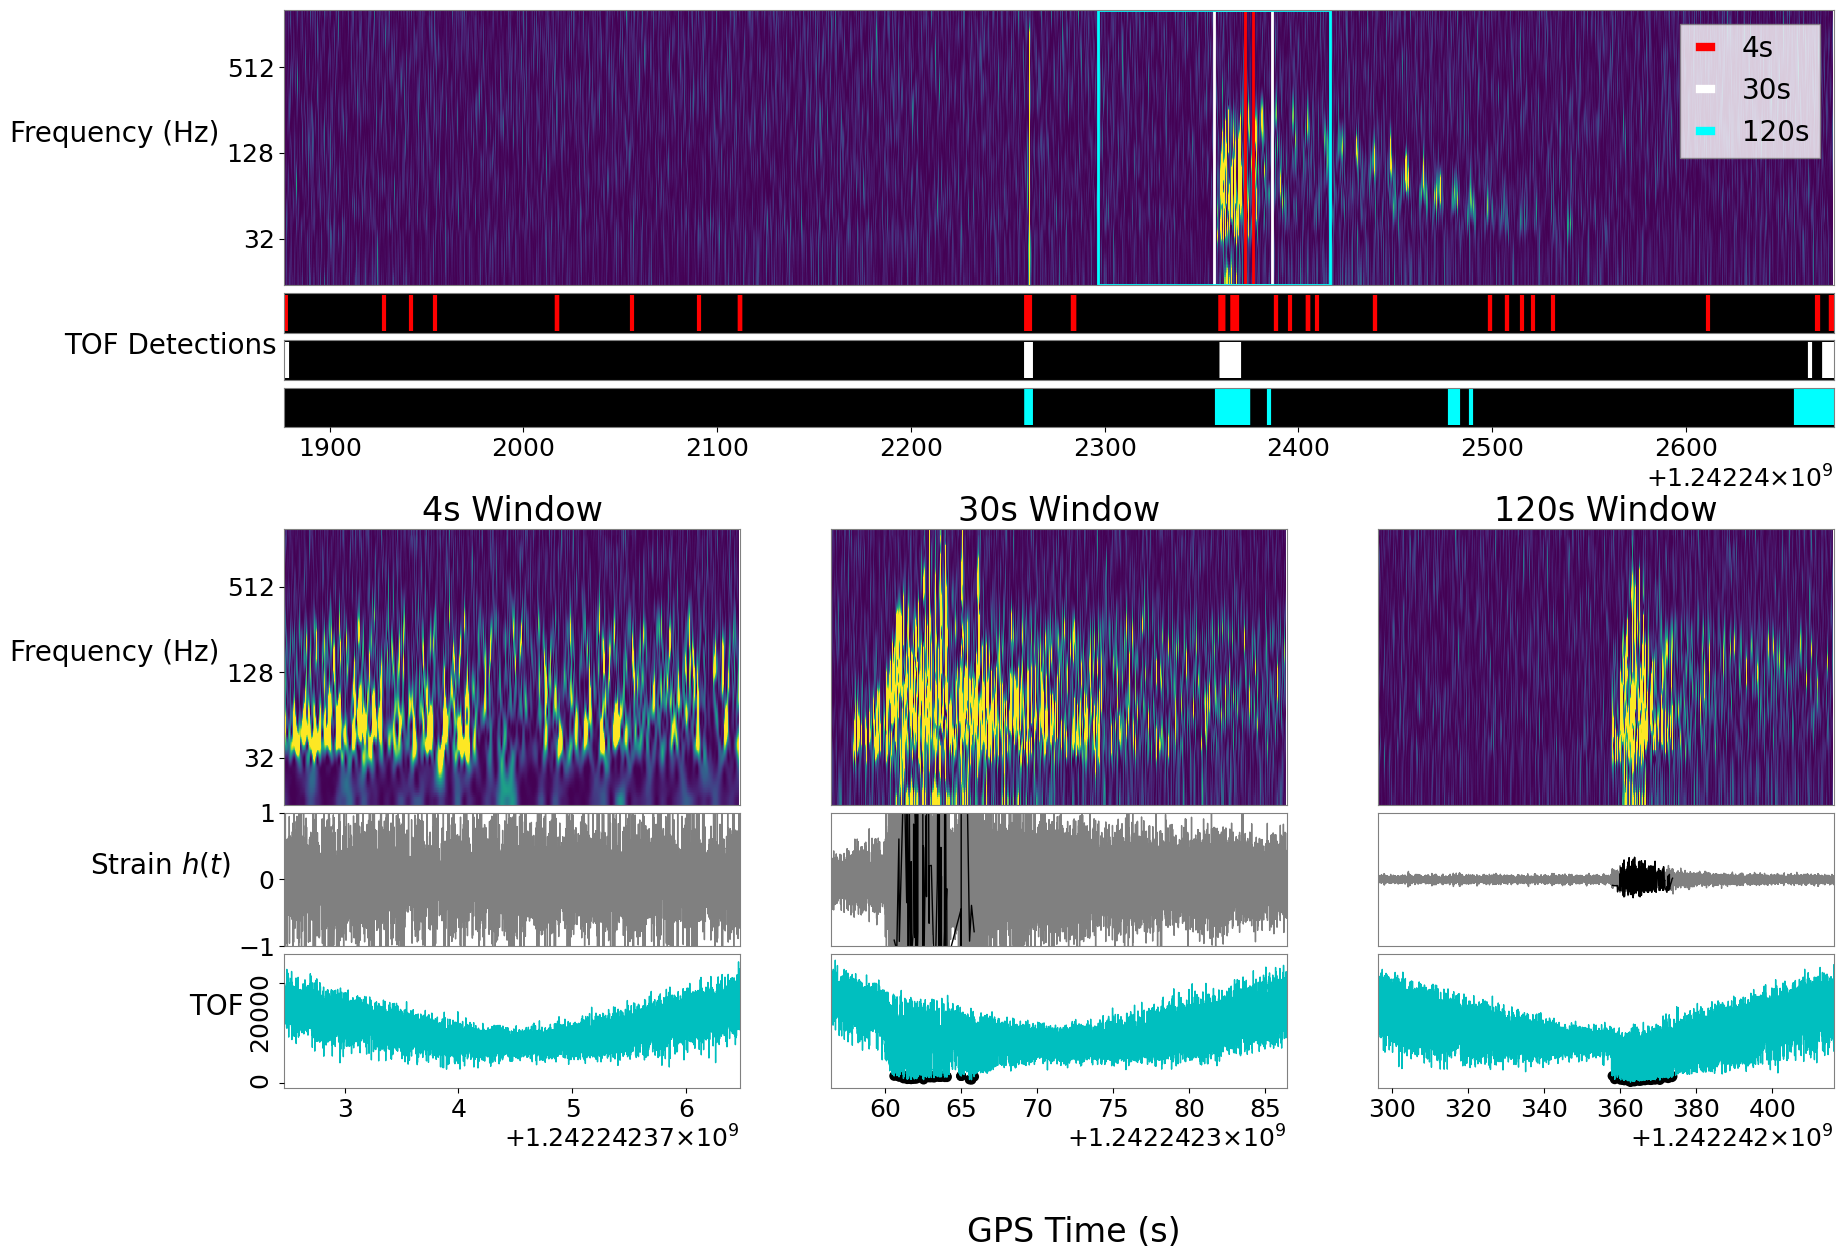

In [9]:
plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels

fig = plt.figure(figsize=(20,14))

grid_shape = (23, 3)
long = plt.subplot2grid(grid_shape, (0,0), rowspan=6, colspan=3)
long.imshow(qscan, vmin=0, vmax=25)
long.set_xlim(start, stop)
long.set_xticks([])
long.set_yscale('log', base=2)
long.set_ylabel('Frequency (Hz)', rotation=90, ha='right')
long.ticklabel_format(axis='x', useOffset=False)
long.grid(False)
#cbar = long.colorbar()
#cbar.set_label('Normalized energy')

lo, hi = long.get_ylim()
labels = ['4s', '30s', '120s']
colors = ['red', 'white', 'cyan']
custom_lines = [lines.Line2D([0], [0], color=c, lw=4) for c in colors]
long.legend(custom_lines, labels)

for i, win in enumerate(WINDOWS):
    label = labels[i]
    color = colors[i]
    left, right = win
    long.add_patch(
        patches.Rectangle(
            (left, lo), right-left, hi-lo,
            edgecolor=color,
            fill=False,
            lw=2
        )
    )

for i, outliers in enumerate(outlier_times.values()):
    ax = plt.subplot2grid(grid_shape, (6+i, 0), colspan=3)
    ax.vlines(outliers, -1, 1, color=colors[i], linewidth=3)
    ax.set_xlim(start, stop)
    if i < 2: ax.set_xticks([])
    if i == 1: ax.set_ylabel('TOF\nDetections', rotation=90, ha='right')
    ax.set_yticks([])
    ax.grid(False)
    ax.set_facecolor('black')

winplts = [plt.subplot2grid(grid_shape, (grid_shape[0]-12, i), rowspan=6) for i in range(3)]
for lab, win in zip(labels, winplts):
    win.set_title(f'{lab} Window')
    
stnplts = [plt.subplot2grid(grid_shape, (grid_shape[0]-6, i), rowspan=3) for i in range(3)]
tofplts = [plt.subplot2grid(grid_shape, (grid_shape[0]-3, i), rowspan=3) for i in range(3)]

for i, ctof, window, win, stn, tof in zip(list(range(3)), ctofs, WINDOWS, winplts, stnplts, tofplts):
    win.imshow(
        rdata.q_transform(outseg=window, qrange=(4, 64), frange=(15, 2048), fres=0.5), 
        vmin=0, vmax=25
    )
    win.set_yscale('log', base=2)
    xlim = win.get_xlim()
    stn.set_xlim(*xlim)
    tof.set_xlim(*xlim)
    win.set_xticks([])
    stn.set_xticks([])
    if i == 0:
        win.set_ylabel('Frequency (Hz)', rotation=90, ha='right')
        stn.set_ylabel('Strain\n$h(t)$', rotation=90, ha='right')
        tof.set_ylabel('TOF', rotation=90, ha='right')
    else:
        win.set_yticks([])
        stn.set_yticks([])
        tof.set_yticks([])
    
    data, times = ctof.get_truncated_data()
    scores = ctof.get_outlier_factors()
    outliers = ctof.get_outlier_indices()
    stn.plot(times, data, color='grey', linewidth=1)
    stn.plot(times[outliers], data[outliers], color='k', linewidth=1)
    tof.plot(times, scores, color='c', linewidth=1)
    tof.scatter(times[outliers], scores[outliers], s=50, facecolors='k', edgecolors='none')
    
    win.grid(False)
    stn.grid(False)
    tof.grid(False)

stn_ylim = (min([stn.get_ylim()[0] for stn in stnplts]), max([stn.get_ylim()[1] for stn in stnplts]))
for stn in stnplts:
    stn.set_ylim(-1,1)

tof_ylim = (min([tof.get_ylim()[0] for tof in tofplts]), max([tof.get_ylim()[1] for tof in tofplts]))
for tof in tofplts:
    tof.set_ylim(*tof_ylim)
tofplts[0].ticklabel_format(axis='y', style='plain')
tofplts[0].tick_params(axis='y', labelrotation=90)

fig.text(0.52, 0, 'GPS Time (s)', ha='center', fontsize=24)
#fig.text(0, 0.55, 'Spectrogram Frequency (Hz)', rotation=90, va='baseline')
fig.tight_layout(w_pad=0, h_pad=0.1)
plt.savefig('data/fig3.pdf', bbox_inches='tight')

## OPA Figure



In [4]:
from collections import defaultdict

O3_IDS = {
    'candidate': [
        'S190408an', 'S190412m', 'S190421ar', 'S190425z', 'S190426c', 'S190503bf', 'S190510g', 'S190512at',
        'S190513bm', 'S190517h', 'S190519bj', 'S190521g', 'S190521r', 'S190602aq', 'S190630ag', 'S190701ah',
        'S190706ai', 'S190707q', 'S190718y', 'S190720a', 'S190727h', 'S190728q', 'S190814bv', 'S190828j',
        'S190828l', 'S190901ap', 'S190910d', 'S190910h', 'S190915ak', 'S190923y', 'S190924h', 'S190930s',
        'S190930t', 'S191105e', 'S191109d', 'S191129u', 'S191204r', 'S191205ah', 'S191213g', 'S191215w',
        'S191216ap', 'S191222n', 'S200105ae', 'S200112r', 'S200114f', 'S200115j', 'S200128d', 'S200129m',
        'S200208q', 'S200213t', 'S200219ac', 'S200224ca', 'S200225q', 'S200302c', 'S200311bg', 'S200316bj'
    ],
    'retracted': [
        'S200308e', 'S200303ba', 'S200116ah', 'S200108v', 'S200106au', 'S200106av', 'S191225aq', 'S191220af',
        'S191213ai', 'S191212q', 'S191124be', 'S191120at', 'S191120aj', 'S191117j', 'S191110af', 'S191110x',
        'S190928c', 'S190829u', 'S190822c', 'S190816i', 'S190808ae', 'S190524q', 'S190518bb', 'S190405ar'
    ]
}

data_dir = 'data/o3_losses'
losses_by_detector = defaultdict(dict)
losses_by_event = defaultdict(dict)

for path in os.listdir(data_dir):
    full_path = os.path.join(data_dir, path)
    if not os.path.isdir(full_path):
        continue
    if len(os.listdir(full_path)) == 0:
        os.rmdir(full_path)
        continue
    with open(os.path.join(full_path, 'loss.txt'), 'r') as fi:
        loss = float(fi.read())
        event_id, det = path.split('_')
        losses_by_detector[det][event_id] = loss
        losses_by_event[event_id][det] = loss

Number of retracted events: 5
Number of candidate events: 23


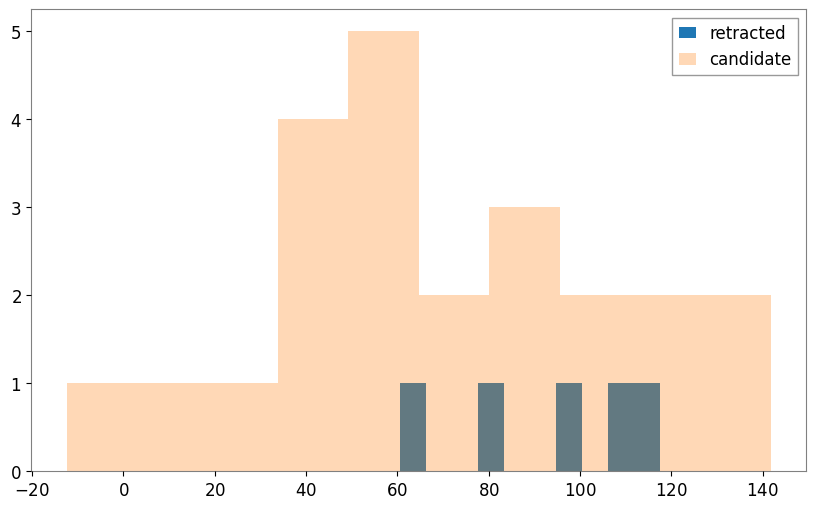

In [5]:
retracted_hist = []
candidate_hist = []
for event_id, event_dict in losses_by_event.items():
    min_loss = min(event_dict.values())
    if event_id in O3_IDS['retracted']:
        retracted_hist.append(min_loss)
    else:
        candidate_hist.append(min_loss)

print('Number of retracted events:', len(retracted_hist))
print('Number of candidate events:', len(candidate_hist))

fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(retracted_hist, label='retracted', alpha=1)
ax.hist(candidate_hist, label='candidate', alpha=0.3)
ax.grid(False)
ax.legend()